<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#План" data-toc-modified-id="План-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>План</a></span><ul class="toc-item"><li><span><a href="#Функции-для-визуализации" data-toc-modified-id="Функции-для-визуализации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции для визуализации</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Тестирование-меньшей-выборки" data-toc-modified-id="Тестирование-меньшей-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Тестирование меньшей выборки</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Тестирование-большей-выборки" data-toc-modified-id="Тестирование-большей-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Тестирование большей выборки</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

## План
Для начала нам нужно будет убрать регулярные выражения(элементы разметки или знаки препинания) и стоп слова чтобы избавться от лишней информации. Лемматизацию проводить не нужно, потому-что BERT сама понимает формы слов. Потом добавим маркеры начала и конца предложения. Затем прведем токнизацию и векторизацию текстов, чтобы модель могла их воспринимать.

Особенность BERT в том, что она может только заполнять пропуски в предложениях и отвечать на вопрос, связаны ли два предложения или нет. Чтобы решать задачи классификации, нужно надстроить над BERT какую-нибудь простенькую модель, которая будет принимать на вход предсказания BERT.

После подготовки построим, обучиим и проверим коненечную модель.

Целевой метрикой выступает F1-мера, нужно чтобы ее значение было не ниже 0.75

In [1]:
import pandas as pd

import numpy as np

import pandas as pd

import torch

import transformers as ppb


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 


import warnings
warnings.filterwarnings("ignore")

from tqdm import notebook 

import tqdm

import seaborn as sns

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

### Функции для визуализации

In [2]:
#часть ниже нужна для визуализации
def calculate_tpr_fpr(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    tpr =  TP/(TP + FN)
    fpr = 1 - TN/(TN+FP)
    return tpr, fpr

def get_n_roc_coordinates(y_real, y_proba, n = 50):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True):
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Подготовка

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

Из-за большого количества данных мы вынуждены взять только 10% от изначального обьема. данные распределены равномерно по всему датасету. я узнал это, когда подбирал оптимальный размер выборки. соотношение 1 и 0 оставалось одним и тем же, при уменьшении выборки. этого хватает, чтобы мы могли безболененно откинуть часть данных

In [4]:
data_shorten = data[0:15957]
data_shorten.shape

(15957, 2)

In [5]:
data_shorten.toxic.value_counts()

0    14343
1     1614
Name: toxic, dtype: int64

In [6]:
display(data.head())
data.shape

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


(159571, 2)

In [7]:
data.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [8]:
asd = data.copy()

In [9]:
#data[(data.toxic == 0) | (data.toxic == 1[0])]
ads  = asd[asd.toxic == 1].append(asd[asd.toxic == 0][0:16225])

In [10]:
import re

In [11]:
ads = ads.reset_index(drop=True)

In [12]:
#ads = re.sub(r"[^a-zA-Z' ]", ' ', ads)
[re.sub(r"[^a-zA-Z' ]", ' ', x) for x in list(ads.text.values)]

ads.text = ads.text.apply(lambda x: " ".join(re.sub(r"[^a-zA-Z' ]", ' ', x).split()) )
ads.toxic.value_counts()

0    16225
1    16225
Name: toxic, dtype: int64

In [16]:
tokenized_3 = ads.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length = 70)))

In [17]:
padded_3 = np.array([i + [0]*(70-len(i)) for i in tokenized_3.values])
attention_mask_3 = np.where(padded_3 != 0, 1, 0)

In [18]:
embeddings_3 = []
batch_size = 65
for i in notebook.tqdm(range(padded_3.shape[0] // batch_size)):
    batch_3 = torch.LongTensor(padded_3[batch_size*i:batch_size*(i+1)])
    attention_mask_batch_3 = torch.LongTensor(attention_mask_3[batch_size*i:batch_size*(i+1)])
    batch_embeddings_3 = model(batch_3, attention_mask=attention_mask_batch_3)
    with torch.no_grad():
        batch_embeddings_3 = model(batch_3, attention_mask=attention_mask_batch_3) 
    embeddings_3.append(batch_embeddings_3[0][:,0,:].numpy())

  0%|          | 0/499 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
del batch_3
del attention_mask_batch_3
del batch_embeddings_3

In [32]:
data.shape

(159571, 2)

In [20]:
dsds = data[135000:150000]
dsds.text = dsds.text.apply(lambda x: " ".join(re.sub(r"[^a-zA-Z' ]", ' ', x).split()) )
dsds.toxic.value_counts()

0    13542
1     1458
Name: toxic, dtype: int64

In [21]:
tokenized_4 = dsds.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length = 70)))

In [22]:
padded_4 = np.array([i + [0]*(70-len(i)) for i in tokenized_4.values])
attention_mask_4 = np.where(padded_4 != 0, 1, 0)

In [37]:
embeddings_4 = []
batch_size = 65
for i in notebook.tqdm(range(padded_4.shape[0] // batch_size)):
    batch_4 = torch.LongTensor(padded_4[batch_size*i:batch_size*(i+1)])
    attention_mask_batch_4 = torch.LongTensor(attention_mask_4[batch_size*i:batch_size*(i+1)])
    batch_embeddings_4 = model(batch_4, attention_mask=attention_mask_batch_4)
    with torch.no_grad():
        batch_embeddings_4 = model(batch_4, attention_mask=attention_mask_batch_4) 
    embeddings_4.append(batch_embeddings_4[0][:,0,:].numpy())

  0%|          | 0/230 [00:00<?, ?it/s]

In [38]:
del batch_4
del attention_mask_batch_4
del batch_embeddings_4

In [29]:
torch.cuda.is_available()

False

## Обучение

In [48]:
dsds.shape

(15000, 2)

In [106]:
features_train_3 = np.concatenate(embeddings_3) 
target_train_3 = ads.toxic[:32435]

features_valid, features_test = train_test_split(np.concatenate(embeddings_4) , shuffle=False, test_size=0.4)
target_valid, target_test = train_test_split(dsds.toxic[:14950], shuffle=False, test_size=0.4)

In [102]:
model_log = LogisticRegression(random_state=1234, C = 10, solver = 'saga')
model_log.fit(features_train_3, target_train_3)
log_probas = model_log.predict_proba(features_valid)
log_probas_of_1 = log_probas[:, 1]
log_probas_of_1

array([0.6165781 , 0.30846366, 0.0265985 , ..., 0.02024329, 0.05730441,
       0.87498254], dtype=float32)

In [103]:
best_f1_log_thr = 0
for i in notebook.tqdm(np.arange(0,1,0.005)):
    asda = pd.Series([own_activator(i, x) for x in log_probas_of_1])
    if f1_score(target_valid, asda) > best_f1_log_thr:
        best_f1_log_thr = f1_score(target_valid, asda)
        best_ii = i
print(best_f1_log_thr, ' ', best_ii)

  0%|          | 0/200 [00:00<?, ?it/s]

0.7491166077738516   0.81


In [107]:
#model_log = LogisticRegression(random_state=1234, C = 10, solver = 'saga')
#model_log.fit(features_train_3, target_train_3)
log_probas = model_log.predict_proba(features_test)
log_probas_of_1 = log_probas[:, 1]
asda = pd.Series([own_activator(0.81, x) for x in log_probas_of_1])
f1_score(target_test, asda)

0.758893280632411

In [66]:
best_f1_log = 0
for i in [0.001, 0.01, 0.1, 1 , 10, 100]:
    for k in notebook.tqdm(['newton-cg', 'liblinear', 'sag']):
        model_log = LogisticRegression(random_state=1234, C = i,  solver = k)
        model_log.fit(features_train_3, target_train_3)
        log_probas = model_log.predict_proba(features_valid)
        log_probas_of_1 = log_probas[:, 1]
        asda = pd.Series([own_activator(0.84, x) for x in log_probas_of_1])
        asda = pd.Series(log_probas_of_1).apply(lambda x:own_activator(0.84, x))
        if f1_score(target_valid, asda) > best_f1_log:
            best_f1_log = (target_valid, asda)
            best_c = i
            best_solver = k
    print(f'пока лучшее f1 = {best_f1_log} при С = {best_c} и solver = {best_solver}')
    print('----------------------------------------------------------------')
print(f'лучшее значение f1 = {best_f1_log} при С = {best_c} и  solver = {best_solver}')

  0%|          | 0/3 [00:00<?, ?it/s]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
from tqdm import notebook
batch_size = 65 # для примера возьмем такой батч, где будет всего две строки датасета
embeddings_3 = [] 
for i in notebook.tqdm(range(padded_3.shape[0] // batch_size)):
        batch_3 = torch.LongTensor(padded_3[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
        attention_mask_batch_3 = torch.LongTensor(attention_mask_3[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            model.cuda()
            batch_embeddings_3 = model(batch_3, attention_mask=attention_mask_batch_3)

        embeddings_3.append(batch_embeddings_3[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch_3
        del attention_mask_batch_3
        del batch_embeddings_3

features_3 = np.concatenate(embeddings_3) 

  0%|          | 0/499 [00:00<?, ?it/s]

AssertionError: Torch not compiled with CUDA enabled

Как мы можем заметить, классы не сбалансированны. По идее, это не должно вызвать проблем, просто укажем аргумент stratify=Target, тогда train_test_split равномерно распределит наблюдения с разными целевыми признаками. с учетом того, что состовляющей целевой метрики является precision, если возникнут проблемы - то проведем балансировку классов.

### Тестирование меньшей выборки 

In [14]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [15]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


на этои этапе было решено ограничить количесво токенов до 50

In [6]:
tokenized = data_shorten.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length = 50)))

In [26]:
tokenized

0        [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1        [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2        [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3        [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4        [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                               ...                        
15952    [101, 22073, 2216, 22073, 2024, 7570, 18752, 2...
15953    [101, 23156, 2017, 1005, 2128, 2085, 2019, 474...
15954    [101, 1045, 1005, 2310, 2464, 10287, 2006, 199...
15955    [101, 7632, 1010, 1996, 3522, 10086, 2017, 208...
15956    [101, 10166, 1010, 2054, 2019, 9788, 2079, 191...
Name: text, Length: 15957, dtype: object

In [27]:
sorted([len(x) for x in tokenized])[-1]

50

In [7]:
padded = np.array([i + [0]*(50-len(i)) for i in tokenized.values])

In [8]:
attention_mask = np.where(padded != 0, 1, 0)

In [30]:
padded

array([[  101,  7526,  2339, ...,  1996, 23561,   102],
       [  101,  1040,  1005, ...,     0,     0,     0],
       [  101,  4931,  2158, ...,  3436,  2084,   102],
       ...,
       [  101,  1045,  1005, ...,  2897,  1011,   102],
       [  101,  7632,  1010, ...,   102,     0,     0],
       [  101, 10166,  1010, ...,     0,     0,     0]])

In [31]:
len([x for x in padded if 0 not in x])# смотрим, сколько твитов у которых токенов больше, чем 50

8337

In [18]:
# input_ids = torch.tensor(padded)  
# attention_mask = torch.tensor(attention_mask)

# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 24510105600 bytes.

In [9]:
embeddings = []
batch_size = 100
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch) 
    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 

  0%|          | 0/159 [00:00<?, ?it/s]

In [10]:
embeddings

[array([[ 0.28003666, -0.08690989, -0.15267448, ...,  0.10257843,
          0.3546069 ,  0.39401293],
        [-0.11879845, -0.15656321,  0.23836775, ..., -0.04899776,
          0.5435743 ,  0.51480484],
        [ 0.04395515,  0.0410918 , -0.18806638, ...,  0.07458772,
          0.54399335,  0.3369531 ],
        ...,
        [-0.09021518, -0.03307031, -0.20066275, ..., -0.1549456 ,
          0.17295207,  0.3198463 ],
        [-0.04777775, -0.16367109, -0.05680871, ..., -0.07147679,
          0.44510376,  0.46170077],
        [ 0.15337658, -0.01468803, -0.03439949, ..., -0.13028653,
          0.3140119 ,  0.32436538]], dtype=float32),
 array([[-0.07468868, -0.15671766, -0.02642004, ...,  0.15805066,
          0.5367777 ,  0.36212263],
        [-0.06705604,  0.09938391, -0.13911134, ..., -0.24993877,
          0.45354423,  0.26263857],
        [ 0.11662726, -0.07986452,  0.05257642, ..., -0.04120887,
          0.43394932,  0.4149565 ],
        ...,
        [-0.10578889,  0.14391814, -0.1

In [11]:
features = np.concatenate(embeddings)

In [24]:
pd.Series([x.max() for x in features if x.max()>1]).describe()

count    15899.000000
mean         3.364135
std          0.231531
min          1.054446
25%          3.222684
50%          3.379812
75%          3.523281
max          4.177414
dtype: float64

In [ ]:
все значения находятся примерно в одном диапазоне. значит масштабирование особо не поможет

### LogisticRegression

In [38]:
model_log = LogisticRegression(random_state=1234)
model_log.fit(features[0:7950], data[0:7950].toxic)

LogisticRegression(random_state=1234)

In [39]:
pred_log = model_log.predict(features[7950:15900])

мы не можем позволить себе валидационную выборку из-за ограничений скорости вычислений, но мы компенсируем это тем, что обучим лучшую модель на всех данных, в том числе и на тестовых, чтобы конечная модель делала более точные предсказания.

In [36]:
pd.Series(pred_log).value_counts()

0    6593
1    1357
dtype: int64

In [42]:
f1_log = f1_score(data[7950:15900].toxic, pred_log)
f1_log

0.6809137803979366

In [44]:
cf_matrix_log = confusion_matrix(data[7950:15900].toxic, pred_log)

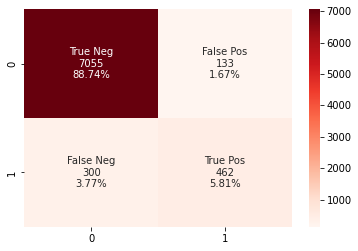

In [57]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_log.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_log.flatten()/np.sum(cf_matrix_log)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_log, annot=labels, fmt='', cmap='Reds');

суммарно около 5 процентов неправильных предказаний. нормально

я пишу содержание этой ячейки после того, как проверил катбуст. и самый лучший результат мы получили используя логическую регрессию, что наталкивает на мысль, что берт слишком умный и уже сделал основную часть работы и сложные модели переобучаются на выходных данных берта. есть два пути решения проблемы. посмотреть на важность признаков и отбросить ненужные или упростить лучшую модель.(признаков 700+ и сидеть-смотреть какие сильно влияют на результат а какие нет- это неблагодарная задача, поэтому давайте сначала упростим модельЮ посмотрим на результат и если он на не устроит- то поменяем порог активации(что вряд ли поможет потому-что полнота у той модели приемлимая), если и в этом случае нас не устроит результат то мы можем либо подбирать все вышеперечисленное одновременно, что очень времязатратно либо увеличить выборку, что тоже времязатратно.)

In [ ]:
best_f1_log = 0
for i in [0.001, 0.01, 0.1, 1 , 10, 100]:
    for k in notebook.tqdm(['newton-cg', 'lbfgs', 'liblinear', 'sag']):
        model_log = LogisticRegression(random_state=1234, C = i,  solver = k)
        model_log.fit(features[0:7950], data[0:7950].toxic)
        if f1_score(data[7950:15900].toxic, model_log.predict(features[7950:15900])) > best_f1_log:
            best_f1_log = f1_score(data[7950:15900].toxic, model_log.predict(features[7950:15900]))
            best_c = i
            best_solver = k
    print(f'пока лучшее f1 = {best_f1_log} при С = {best_c} и solver = {best_solver}')
    print('----------------------------------------------------------------')
print(f'лучшее значение f1 = {best_f1_log} при С = {best_c} и  solver = {best_solver}')

In [89]:
best_solver

'newton-cg'

мы улучшили показатель f1 на 0.001. что можно обьяснить случайностью. давайте поменяем порог активации, для этого напишем функцию

In [43]:
def own_activator(threshold, probas):
    if probas > threshold:
        return 1
    else:
        return 0

In [95]:
model_log = LogisticRegression(random_state=1234,   solver = 'newton-cg')
model_log.fit(features[0:7950], data[0:7950].toxic)
log_probas = model_log.predict_proba(features[7950:15900])
log_probas_of_1 = log_probas[:, 1]
log_probas_of_1

array([0.03032291, 0.34165564, 0.00662105, ..., 0.00051991, 0.00147509,
       0.01649846], dtype=float32)

In [112]:
best_f1_log_thr = 0
for i in notebook.tqdm(np.arange(0,1,0.005)):
    asda = pd.Series([own_activator(i, x) for x in log_probas_of_1])
    if f1_score(data[7950:15900].toxic, asda) > best_f1_log_thr:
        best_f1_log_thr = f1_score(data[7950:15900].toxic, asda)
        best_ii = i
print(best_f1_log_thr, ' ', best_ii)

  0%|          | 0/200 [00:00<?, ?it/s]

0.7005721551176097   0.325


пока лучший результат. давайте еще кое-что попробуем, не получится-увеличим выборку. я хочу сейчас отмасштабировать данные. я не прибегаю к ансамблю потому-что мы предположили, что чем проще модель-тем лучше. если совсем ничего не поможет, придется делать ансамбль

с масштабированием данных скользская ситуацияю кто то считает, что один скалер нужно обучать на тренировочной выборке и им же масштабировать тестовую выборку, кто-то считает, что нужно два по-разному обученных скалера, чтобы модель была безоговорочно готова к реальным данным. я считаю, что второй вариант правильнее. но меня просили выполнять масштабирование первым способом, поэтому давайте так и поступим. в документации про это ни слова.

In [116]:
features_for_scal = pd.DataFrame(data = features) #на самом деле надо было это раньше сделать
features_for_scal_train = features_for_scal[0:7950]
features_for_scal_test = features_for_scal[7950:15900]

In [117]:
scaler_lin = StandardScaler().fit(features_for_scal_train)
features_for_scal_train = scaler_lin.transform(features_for_scal_train)
features_for_scal_test = scaler_lin.transform(features_for_scal_test)

In [118]:
model_log_scaled = LogisticRegression(random_state=1234,solver = 'newton-cg')
model_log_scaled.fit(features_for_scal_train, data[0:7950].toxic)
pred_scaled = model_log.predict(features_for_scal_test)
f1_score(data[7950:15900].toxic, pred_scaled)

0.5237730061349692

In [119]:
model_log = LogisticRegression(random_state=1234,   solver = 'newton-cg')
model_log.fit(features_for_scal_train, data[0:7950].toxic)
log_probas = model_log.predict_proba(features_for_scal_test)
log_probas_of_1 = log_probas[:, 1]
log_probas_of_1

array([2.7113056e-03, 3.5822305e-01, 1.6999491e-04, ..., 2.7889500e-06,
       4.2814148e-07, 8.1155375e-03], dtype=float32)

In [120]:
best_f1_log_thr = 0
for i in notebook.tqdm(np.arange(0,1,0.005)):
    asda = pd.Series([own_activator(i, x) for x in log_probas_of_1])
    if f1_score(data[7950:15900].toxic, asda) > best_f1_log_thr:
        best_f1_log_thr = f1_score(data[7950:15900].toxic, asda)
        best_ii = i
print(best_f1_log_thr, ' ', best_ii)

  0%|          | 0/200 [00:00<?, ?it/s]

0.6487549148099606   0.47000000000000003


не впечатляет. ничего не остается, кроме как увеличить выборку в 5 раз.

In [4]:
data.shape

(159571, 2)

### Тестирование большей выборки

In [5]:
data_shorten_2 = data[0:80000]

<a id='tokens'></a>
Вообще, уменьшение количества токенов до 50(при стандарте равном 512) это вынужденная мера. Количество токенов, в отличии от количество строк сильнее влияет на скорость прогонки через берт. если при увеличении количиства строк на n, количество данных увеличивается на n, то при увеличении количество токенов на k, при том, что уже есть i строк мы увеличим количество данных на на k*i. 50- опытоно подобранная величина, которая не вызывает рпоблем.

наглядный пример. при размере батча в 100, мой компьютер обрабатывал один батч в среднем за 10.6 секунд при 50 токенах и за ~17 секунд при 75 токенах.

значит, если мы увеличим колчиество токенов в полтора раза то время затраченное на вычичсление увеличится на 6.4n с, в то время как при увеличении обьема данных в полтора раза при таком же количестве токенов время увеличится на 5.3n c

In [6]:
tokenized_2 = data_shorten_2.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length = 70)))

In [7]:
padded_2 = np.array([i + [0]*(70-len(i)) for i in tokenized_2.values])

In [8]:
attention_mask_2 = np.where(padded_2 != 0, 1, 0)

In [11]:
padded_2.shape[0] // 75

1066

In [9]:
embeddings_2 = []
batch_size = 65
for i in notebook.tqdm(range(padded_2.shape[0] // batch_size)):
    batch_2 = torch.LongTensor(padded_2[batch_size*i:batch_size*(i+1)])
    attention_mask_batch_2 = torch.LongTensor(attention_mask_2[batch_size*i:batch_size*(i+1)])
    batch_embeddings_2 = model(batch_2, attention_mask=attention_mask_batch_2)
    with torch.no_grad():
        batch_embeddings_2 = model(batch_2, attention_mask=attention_mask_batch_2) 
    embeddings_2.append(batch_embeddings_2[0][:,0,:].numpy())

  0%|          | 0/1230 [00:00<?, ?it/s]

In [11]:
features_2 = np.concatenate(embeddings_2)

давайте обучим нашу модель на 80% данных, проведем валидацию на 10% и оставшиеся оставим на тестирование

In [13]:
features_final = pd.DataFrame(data = features_2)
features_final.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.220490,-0.097744,-0.073250,-0.071392,-0.085661,-0.183036,0.322567,0.242754,-0.038898,-0.271066,...,0.177155,-0.026148,0.086816,-0.171983,0.303477,0.019843,-0.199227,0.153798,0.416239,0.403389
1,-0.118798,-0.156563,0.238368,-0.128910,-0.122928,-0.096002,0.643841,0.153690,-0.207519,-0.335488,...,0.098510,-0.217268,0.038986,-0.440684,0.285150,-0.148382,0.210517,-0.048998,0.543574,0.514805
2,0.075954,0.061317,-0.122161,-0.135580,-0.120700,-0.396360,0.039420,0.519339,-0.130742,-0.324620,...,0.017995,-0.276312,0.167717,-0.168578,0.155621,0.323910,-0.154194,0.106488,0.530345,0.335555
3,0.067235,-0.040190,0.106863,-0.184665,0.028552,-0.340553,0.065569,0.265943,-0.061013,-0.209012,...,0.191439,-0.054419,-0.013607,-0.072732,0.213455,-0.039148,-0.266562,-0.024168,0.337838,0.367264
4,-0.116651,-0.038441,-0.080841,-0.028249,-0.014768,-0.308648,0.141258,0.533530,-0.274986,-0.334551,...,-0.012091,-0.161019,0.241566,-0.178456,0.210459,0.240435,-0.285982,0.031116,0.412562,0.304650


0    892
1    108
Name: toxic, dtype: int64

In [14]:
features_train, features_temp = train_test_split(features_final, shuffle=False, test_size=0.6)
features_valid, features_test = train_test_split(features_temp, shuffle=False, test_size=0.5)

target_train, target_temp = train_test_split(data.toxic[:len(features_final)], shuffle=False, test_size=0.6)
target_valid, target_test = train_test_split(target_temp, shuffle=False, test_size=0.5)

можно было конечно сначала обьеденить датасеты, потом снова разделить, но зачем проделывать лишнюю работу?

In [47]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
calibrated_cv = CalibratedClassifierCV(
					LinearSVC(
						   C = 3, 
						   intercept_scaling = 1, 
						   class_weight = 'balanced', 
						   random_state = 412
						 ), 
					method = 'sigmoid', 
					cv = 5
					)
text_clf_fl_first = pipeline(
			      [
			       ('tfidfV', 
				TfidfVectorizer(

						 lowercase=True, 
						 sublinear_tf=True, 
						 min_df=10, 
						 norm='l2', 
						 encoding='utf8', 
						 ngram_range=(1, 4) )
						# stop_words=stop_words)
						),
                             ('clf', calibrated_cv)
                           ])

_ = text_clf_fl_first.fit(
			   df_tempr_fl_aos1['Answer'], 
			   df_tempr_fl_aos1['NewClassification']
			  )

TypeError: unhashable type: 'list'

In [116]:
#asd = features_train.join(target_train)
asd = features_train.merge(target_train, how = 'left')#, left_on='lkey', right_on='rkey')
asd.head()
# asd = features_train
# asd['toxic'] = target_train
# asd

MemoryError: Unable to allocate 9.69 GiB for an array with shape (1301031162,) and data type int64

In [93]:
from sklearn.utils import shuffle
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [94]:
dass, asdad = upsample(asd, asd.toxic, 7)
asdad.value_counts()

0    35829
1    29127
Name: toxic, dtype: int64

In [36]:
scaler_lin = StandardScaler().fit(features_train)
features_for_scal_train = scaler_lin.transform(features_train)
features_for_scal_valid = scaler_lin.transform(features_valid)
features_for_scal_test = scaler_lin.transform(features_test)

In [115]:
model_log_extended = LogisticRegression(random_state=1234)
model_log_extended.fit(asd.drop('toxic', axis = 1), asd.toxic)
#выше нужна индексация чтобы точно ничего не перепутать
pred_log_extended = model_log_extended.predict(features_for_scal_valid)
f1_score(target_valid, pred_log_extended)

0.38432934926958834

In [37]:
model_log_extended = LogisticRegression(random_state=1234)
model_log_extended.fit(features_for_scal_train, target_train)
#выше нужна индексация чтобы точно ничего не перепутать
pred_log_extended = model_log_extended.predict(features_for_scal_valid)
f1_score(target_valid, pred_log_extended)

0.7259395050412466

In [25]:
model_log_extended = LogisticRegression(random_state=1234)
model_log_extended.fit(features_train, target_train)
#выше нужна индексация чтобы точно ничего не перепутать
pred_log_extended = model_log_extended.predict(features_valid)
f1_score(target_valid, pred_log_extended)

0.7272727272727273

In [17]:
model_log = LogisticRegression(random_state=1234)
model_log.fit(features_train, target_train)
log_probas = model_log.predict_proba(features_valid)
log_probas_of_1 = log_probas[:, 1]
log_probas_of_1

array([0.03123476, 0.00900383, 0.00167304, ..., 0.03429091, 0.1035808 ,
       0.0688976 ])

<a id=''></a>

In [20]:
best_f1_log_thr = 0
for i in notebook.tqdm(np.arange(0,1,0.005)):
    asda = pd.Series([own_activator(i, x) for x in log_probas_of_1])
    if f1_score(target_valid, asda) > best_f1_log_thr:
        best_f1_log_thr = f1_score(target_valid, asda)
        best_ii = i
print(best_f1_log_thr, ' ', best_ii)

  0%|          | 0/200 [00:00<?, ?it/s]

0.7370517928286853   0.41000000000000003


In [21]:
best_f1_log = 0
for i in [0.001, 0.01, 0.1, 1 , 10, 100]:
    for k in notebook.tqdm(['newton-cg', 'lbfgs', 'liblinear', 'sag']):
        model_log = LogisticRegression(random_state=1234, C = i,  solver = k)
        model_log.fit(features_train, target_train)
        log_probas = model_log.predict_proba(features_valid)
        log_probas_of_1 = log_probas[:, 1]
        asda = pd.Series([own_activator(.355, x) for x in log_probas_of_1])
        if f1_score(target_valid, asda) > best_f1_log:
            best_f1_log = f1_score(target_valid, asda)
            best_c = i
            best_solver = k
    print(f'пока лучшее f1 = {best_f1_log} при С = {best_c} и solver = {best_solver}')
    print('----------------------------------------------------------------')
print(f'лучшее значение f1 = {best_f1_log} при С = {best_c} и  solver = {best_solver}')

  0%|          | 0/4 [00:00<?, ?it/s]

пока лучшее f1 = 0.6714801444043322 при С = 0.001 и solver = sag
----------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

пока лучшее f1 = 0.7186484730344379 при С = 0.01 и solver = lbfgs
----------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

пока лучшее f1 = 0.7432950191570882 при С = 0.1 и solver = liblinear
----------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

пока лучшее f1 = 0.754740834386852 при С = 1 и solver = lbfgs
----------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

пока лучшее f1 = 0.754740834386852 при С = 1 и solver = lbfgs
----------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

пока лучшее f1 = 0.754740834386852 при С = 1 и solver = lbfgs
----------------------------------------------------------------
лучшее значение f1 = 0.754740834386852 при С = 1 и  solver = lbfgs


In [44]:
model_log = LogisticRegression(random_state=1234)
model_log.fit(features_train, target_train)
log_probas = model_log.predict_proba(features_test)
log_probas_of_1 = log_probas[:, 1]
asda = pd.Series([own_activator(0.350, x) for x in log_probas_of_1])
f1_score(target_test, asda)

0.7172264355362946

### DecisionTreeClassifier

In [52]:
model_tree = DecisionTreeClassifier(random_state = 12345)
model_tree.fit(features_train, target_train)
model_tree.tree_.max_depth

KeyboardInterrupt: 

In [ ]:
f1_score(features_valid, target_valid)

без подбора глубины решающее дерево показывает достаточно посредсвенный результат.

In [62]:
best_f1_tree = 0
for i in notebook.tqdm(range(1, 45)):
    model_tree = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model_tree.fit(features[0:7950], data[0:7950].toxic)
    if f1_score(data[7950:15900].toxic, model_tree.predict(features[7950:15900])) > best_f1_tree:
        best_f1_tree = f1_score(data[7950:15900].toxic, model_tree.predict(features[7950:15900]))
        best_depth_tree = i
print(f'лучшее значение f1 = {best_f1_tree} достигается при значении depth = {best_depth_tree}')

  0%|          | 0/44 [00:00<?, ?it/s]

лучшее значение f1 = 0.49918699186991866 достигается при значении depth = 6


In [63]:
model_tree = DecisionTreeClassifier(random_state = 12345, max_depth = 6)
model_tree.fit(features[0:7950], data[0:7950].toxic)

DecisionTreeClassifier(max_depth=6, random_state=12345)

In [64]:
cf_matrix_tree = confusion_matrix(data[7950:15900].toxic, model_tree.predict(features[7950:15900]))

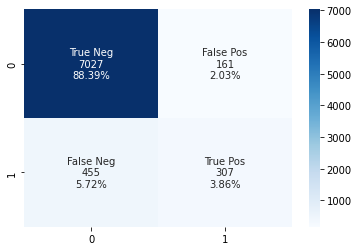

In [65]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_tree.flatten()/np.sum(cf_matrix_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_tree, annot=labels, fmt='', cmap='Blues');

видны очевидные проблемы этой модели. а именно определение положительных значений. FN>TP что значит, что у модели низкое значение полноты и как следствие помойное значение целевой метрики. смысла проверять алгоритм случайного леса особо нет, потому-что они построены по одному и тому же принципу с рещающим деревом и он вряд ли выдаст результат сильно лучше

### CatBoostClassifier

In [33]:
model_cb.max_depth

AttributeError: 'CatBoostClassifier' object has no attribute 'max_depth'

In [85]:
model_cb = CatBoostClassifier( iterations=100, 
                              random_state = 12345, 
                              eval_metric="F1")

In [86]:
model_cb.fit(features_train_3, target_train_3,  plot=True, 
             eval_set=(features_valid, target_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.203765
0:	learn: 0.8059112	test: 0.4412238	best: 0.4412238 (0)	total: 447ms	remaining: 44.2s
1:	learn: 0.8247831	test: 0.5029240	best: 0.5029240 (1)	total: 683ms	remaining: 33.5s
2:	learn: 0.8341223	test: 0.5210872	best: 0.5210872 (2)	total: 892ms	remaining: 28.8s
3:	learn: 0.8391063	test: 0.5326296	best: 0.5326296 (3)	total: 1.1s	remaining: 26.5s
4:	learn: 0.8458870	test: 0.5416259	best: 0.5416259 (4)	total: 1.34s	remaining: 25.5s
5:	learn: 0.8493583	test: 0.5490196	best: 0.5490196 (5)	total: 1.57s	remaining: 24.6s
6:	learn: 0.8530364	test: 0.5507104	best: 0.5507104 (6)	total: 1.77s	remaining: 23.6s
7:	learn: 0.8545934	test: 0.5519922	best: 0.5519922 (7)	total: 1.97s	remaining: 22.6s
8:	learn: 0.8562100	test: 0.5581854	best: 0.5581854 (8)	total: 2.17s	remaining: 22s
9:	learn: 0.8590154	test: 0.5582310	best: 0.5582310 (9)	total: 2.38s	remaining: 21.4s
10:	learn: 0.8618864	test: 0.5625616	best: 0.5625616 (10)	total: 2.58s	remaining: 20.9s
11:	learn: 0.8633476	test

In [73]:
f1_score(data[7950:15900].toxic, model_cb.predict(features[7950:15900]))

0.6227450980392157

## Выводы

Мы убедились в том, насколько BERT мощная модель. Но столкнулись с ограничениями вычисоительной силы домашнего компьютера, не зря такие огромные модели могут обучить только огромные корпорации. Мы пришли к выводу, что для нашей задачи подпшла самая простая модель логической регрессии, которая показала результат лучше, чем CatBoost. и еще, как оказалось, для оценки токсичности твита достаточно первых 50 токенов твита потому-что наша модель показывает достойный уровень f1 метрики, что может служить темой для отдельного иследования.

остальные модели и не стоят сравнения. вот [лучшая модель](#best_model)

давайте посмотрим на ее матрицу ошибок и сравним с константной моделью.

In [ ]:
model_log = LogisticRegression(random_state=1234)
model_log.fit(features_train, target_train)
log_probas = model_log.predict_proba(features_test)
log_probas_of_1 = log_probas[:, 1]
asda = pd.Series([own_activator(0.355, x) for x in log_probas_of_1])
f1_score(target_valid, asda) > best_f1_log_thr:

In [183]:
cf_matrix_tree = confusion_matrix(data[55791:79700].toxic, pd.Series([own_activator(0.335, x) for x in log_probas_of_1]))

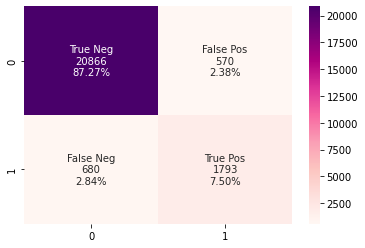

In [184]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_tree.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_tree.flatten()/np.sum(cf_matrix_tree)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_tree, annot=labels, fmt='', cmap='RdPu');

Наша модель хорошо определяет токсичные твиты, только 2.84% от всего набора данных(37.8% от всех 1) модель не угадала.

Давайте посмотрим на AUC-ROC кривую нашей модели

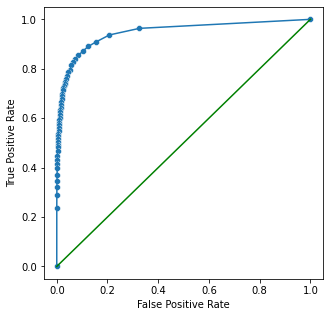

In [189]:
tpr, fpr = get_n_roc_coordinates(data[55791:79700].toxic, log_probas)
# Plots the ROC curve
plot_roc_curve(tpr, fpr)

судя по ROC наша модель лучше определяет 0, чем еденицы, это может быть связанно с дисбалансом классов(график сужен)

как же справится константная модель?

In [193]:
f1_score(data[55791:79700].toxic, pd.Series([1 for x in data[55791:79700].toxic]))
#если мы предскажем все 0 f1 будет 0 потому-что полнота будет равна 0

0.18747630960503373

наша модель явно лучше